In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Function to normalize dataframe and plot a violin plot with n features

In [2]:
def norm_and_set_index(df):
    data = df.iloc[:,1:]
    normed = (data-data.min())/(data.max()-data.min())
    normed.index = df.iloc[:,0]
    return normed

In [3]:
#creates a violin plot for the selected features to view a rough distribution
#df - dataframe of values
#num - number of features to display
#all - set as true to view all features

def violin_plot(df, num = 3, all = False):
    assert num <= len(df.columns), 'You cannot display more features than there are columns'
    
    if all == True:
        #show violin plot of all of the features
        fig, ax = plt.subplots()
        fig.set_size_inches(17, 8)
        ax.violinplot(df.iloc[:,:], showmedians=True)
        ax.set_title('Violin Plot of All Features')
        ax.set_xticks([x for x in range(0,len(df.columns))])
        ax.set_xticklabels(df.columns)
        plt.xticks(rotation=45)
        plt.show()
    else:
        num_features = num
        fig, ax = plt.subplots()
        fig.set_size_inches(17, 8)
        ax.violinplot(df.iloc[:,0:num_features], showmedians=True)
        ax.set_title('Violin plot')
        ax.set_xticks([x for x in range(1,num_features+1)])
        ax.set_xticklabels(df.columns[0:num_features])
        plt.xticks(rotation=45)
        plt.show()

In [4]:
personal_artist_data = pd.read_csv('artist_data.csv')
personal = norm_and_set_index(personal_artist_data)

In [5]:
spotify_artist_data = pd.read_csv('spotify_artist_data.csv')
spotify = norm_and_set_index(spotify_artist_data)

# PCA

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components= 10).fit(personal)
personal_pca = pca.transform(personal)

PCA explained var:  [0.27246345 0.24653749 0.12872212 0.08646179 0.07732439 0.0659411
 0.04025664 0.02605234 0.02175429 0.01415089]


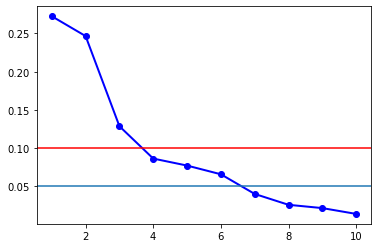

In [8]:
x_axis = np.arange(0,10)+1
plt.plot(x_axis, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.axhline(0.05)
plt.axhline(0.1, color='red')
print('PCA explained var: ', pca.explained_variance_ratio_)

In [11]:
sum(pca.explained_variance_ratio_[0:3])

0.6477230621400192

# Elbow+sillouette to find best K value

In [16]:
from sklearn.cluster import KMeans 

In [17]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS_error(df, kmax):
    #reset index to numbers instead of names
    names = df.index
    df_no_name = df.reset_index(drop=True)
    df_no_name = df_no_name.to_numpy()
    
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(df_no_name)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(df_no_name)
        curr_sse = 0
    
        #calculating the wss - euclidean distance from pt to its cluster and adding to sum
        for i in range(len(df)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (df_no_name[i, 0] - curr_center[0]) ** 2 + (df_no_name[i, 1] - curr_center[1]) ** 2
        print('total wss for k=', k, 'is', curr_sse)
      
        sse.append(curr_sse)
    return sse

In [18]:
wss = calculate_WSS_error(personal, 15)

total wss for k= 1 is 3.3299920850625293
total wss for k= 2 is 2.1104501847529007
total wss for k= 3 is 1.823021819759012
total wss for k= 4 is 1.6084341909740003
total wss for k= 5 is 1.4745346175394598
total wss for k= 6 is 1.3822855712029833
total wss for k= 7 is 1.2287054587306443
total wss for k= 8 is 0.8623431895173593
total wss for k= 9 is 0.9827455502972716
total wss for k= 10 is 0.7047403116023248
total wss for k= 11 is 0.5384787193307867
total wss for k= 12 is 0.5231160463784564
total wss for k= 13 is 0.5976473952524815
total wss for k= 14 is 0.36150423207946786
total wss for k= 15 is 0.510773310702171


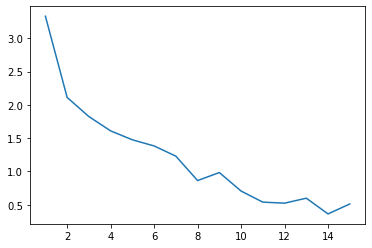

In [19]:
plt.plot(range(1,16), wss)

Based on the elbow, I will use 4 clusters

In [20]:
from sklearn.metrics import silhouette_score

In [21]:
def sil_score(df, kmax):
    sil = []

    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(df)
        labels = kmeans.labels_
        sil.append(silhouette_score(df, labels, metric = 'euclidean'))
    return sil

In [22]:
sil = sil_score(personal, 15)

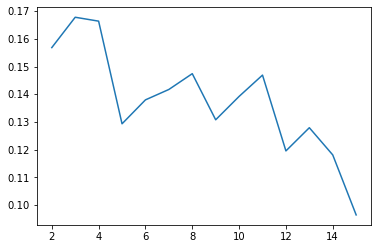

In [23]:
plt.plot(range(2,16), sil)

Although there is wide fluctuation, n=4 is close to the peak sil_score. Going with n=4

# Clustering using K-Means (centroid based)

In [143]:
km_personal = personal.copy()
km_spotify = spotify.copy()

In [144]:
#personal playlist
X_personal = km_personal.to_numpy()
#spotify playlist
X_spotify = km_spotify.to_numpy()

In [145]:
kmean_personal = KMeans(n_clusters=4).fit(X_personal)
kmean_spotify = KMeans(n_clusters=4).fit(X_spotify)

In [146]:
km_personal['km_label'] = kmean_personal.labels_
km_spotify['km_label'] = kmean_spotify.labels_

# Visualize -> PCA 2 components and then KMeans 

In [147]:
pca = PCA(2) 
pca_data_personal = pd.DataFrame(pca.fit_transform(X_personal),columns=['PC1','PC2']) 
pca_data_spotify = pd.DataFrame(pca.fit_transform(X_spotify),columns=['PC1','PC2']) 

In [148]:
kmeans_p = KMeans(n_clusters=4).fit(pca_data_personal)
pca_data_personal['cluster'] = pd.Categorical(kmeans_p.labels_)

kmeans_s = KMeans(n_clusters=4).fit(pca_data_spotify)
pca_data_spotify['cluster'] = pd.Categorical(kmeans_s.labels_)

#add artist names as as column to make it hoverable 
pca_data_personal['artist'] = personal.index
pca_data_spotify['artist'] = spotify.index

#plot
px.scatter(pca_data_personal,x="PC1",y="PC2",color="cluster", hover_data=['artist'], title='Personal Clusters')

In [149]:
px.scatter(pca_data_spotify,x="PC1",y="PC2",color="cluster", hover_data=['artist'], title='Spotify Clusters')

In [151]:
km_final_clusters = pd.DataFrame(
    [
        personal.index,
        kmean_personal.labels_,
        kmean_spotify.labels_
        
    ],
).T
km_final_clusters.columns = ['name', 'personal_clust', 'spotify_clust']

In [152]:
km_final_clusters.sort_values(by = ['spotify_clust'])

,name,personal_clust,spotify_clust
26,kanye,2,0
21,maxo kream,0,0
20,michigan boys,1,0
19,mac miller,2,0
17,kota the friend,0,0
15,kendrick,2,0
14,j cole,1,0
22,nav,1,1
18,lil baby,3,1
12,gunna,1,1


# Using GMM to cluster (distribution based)

In [160]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5)

In [161]:
gmm_personal = personal.copy()
gmm_spotify = spotify.copy()

In [162]:
#personal playlist
X_personal = gmm_personal.to_numpy()
#spotify playlist
X_spotify = gmm_spotify.to_numpy()

In [163]:
gmm_personal_model = gmm.fit(X_personal)
gmm_spotify_model = gmm.fit(X_spotify)

In [164]:
gmm_personal['gmm_label'] = gmm_personal_model.predict(X_personal)
gmm_spotify['gmm_label'] = gmm_spotify_model.predict(X_spotify)

# Visualize --> PCA(2) then GMM

In [166]:
pca = PCA(2) 
pca_data_personal = pd.DataFrame(pca.fit_transform(X_personal),columns=['PC1','PC2']) 
pca_data_spotify = pd.DataFrame(pca.fit_transform(X_spotify),columns=['PC1','PC2']) 

In [167]:
gmm_p = gmm.fit(pca_data_personal)
pca_data_personal['cluster'] = gmm_p.predict(pca_data_personal)

gmm_s = gmm.fit(pca_data_spotify)
pca_data_spotify['cluster'] = gmm_p.predict(pca_data_spotify)

#add artist names as as column to make it hoverable 
pca_data_personal['artist'] = personal.index
pca_data_spotify['artist'] = spotify.index

px.scatter(pca_data_personal,x="PC1",y="PC2",color="cluster", hover_data=['artist'], title='Personal Clusters')

In [168]:
px.scatter(pca_data_spotify,x="PC1",y="PC2",color="cluster", hover_data=['artist'], title='Spotify Clusters')

In [169]:
final_clusters = pd.DataFrame(
    [
        personal.index,
        gmm_personal['gmm_label'],
        gmm_spotify['gmm_label']
        
    ],
).T
final_clusters.columns = ['name', 'personal_clust', 'spotify_clust']

In [170]:
final_clusters.sort_values(by = ['personal_clust'])

,name,personal_clust,spotify_clust
1,21 savage,0,4
18,lil baby,0,4
26,kanye,2,3
15,kendrick,2,3
25,wiz and currency,2,4
19,mac miller,2,3
21,maxo kream,2,3
9,frank ocean,2,2
8,freddie gibbs,2,1
6,daft punk,2,2


In [171]:
#TODO: Add a DBSCAN and learn about how to tune eps (distance) and min_pts hyperparameters